In [301]:
import pandas as pd
import numpy as np
import re
import string
import os
import json
from bidict import bidict
import pickle
import json
import random
import errno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from math import ceil
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [308]:
%matplotlib inline
plt.style.use(['dark_background', 'ggplot'])
sns.set(color_codes=True)
sns.set_palette(sns.color_palette('pastel'))

In [2]:
with open("/data/rali7/Tmp/solimanz/data/datasets/top550/train_ids.pkl", "rb")as f:
    train_ids = pickle.load(f)
with open("/data/rali7/Tmp/solimanz/data/datasets/top550/test_ids.pkl", "rb")as f:
    test_ids = pickle.load(f)
with open("/data/rali7/Tmp/solimanz/data/datasets/top550/jobid/data.json", "r") as f:
    data = json.load(f)

In [324]:
def get_subsequences(sequences):
    sub_seqs = []    
    for seq in sequences:
        for i in range(2,len(seq)):
            sub_seqs.append(seq[:i])
    return sub_seqs

In [197]:
def run_model(model, X_train, train_targets, X_test, test_targets):
    # Train
    print(f"Training Naive Bayes...")
    model.fit(X_train, train_targets)

    # Test
    print("Running trained model on test dataset")
    predicted = model.predict(X_test)
    acc = np.mean(predicted == test_targets)

    print("Model Accuracy: " + str(acc))
    
    return model

def make_X(sequences, vectorizer, vocab_size=None, counts=False, text=True):
    if text:
        X = vectorizer.transform(sequences)
    else:
        X = np.zeros((len(sequences), vocab_size), dtype=np.int16)
        for i, seq in enumerate(sequences):
            for elem in seq:
                if counts:
                    X[i][elem] += 1
                else:
                    X[i][elem] = 1

    return X

In [170]:
def apply_stemming(data):
    """data is a list of sequences"""
    
    stemmer = SnowballStemmer('english')
    pattrn = re.compile(r"[-/,\.\\\s_]")
    
    output = []
    
    for sequence in data:
        stemmed_seq = []        
        for title in sequence:
            stemmed = ""            
            for token in re.split(pattrn, title):
                if stemmed:
                    stemmed += " " + stemmer.stem(token)
                else:
                    stemmed += stemmer.stem(token)
            stemmed_seq.append(stemmed)
            
        output.append(stemmed_seq)

    return [" ".join(seq) for seq in output]

In [326]:
def get_data_sets(json_path, tokenize_titles=True, use_stemmer=True, use_sub_seq=False):
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    title_id = bidict(data["title_to_id"])
    train_data = data["train_data"]
    test_data = data["test_data"]
    
    if use_sub_seq:
        train_data = get_subsequences(train_data)
        test_data = get_subsequences(test_data)
    
    
    if tokenize_titles:
        train_seq = [[title_id.inv[i] for i in title_seq[:-1]] for title_seq in train_data]
        test_seq = [[title_id.inv[i] for i in title_seq[:-1]] for title_seq in test_data]
    else:
        train_seq = [[re.sub(r"[\W\s]", "_", title_id.inv[i]) for i in title_seq[:-1]] 
                     for title_seq in train_data]
        test_seq = [[re.sub(r"[\W\s]", "_", title_id.inv[i]) for i in title_seq[:-1]] 
                    for title_seq in test_data]
    
    train_targets = [seq[-1] for seq in train_data]
    test_targets = [seq[-1] for seq in test_data]
    
    if tokenize_titles and not use_stemmer:
        train_text = [" ".join(title_seq).replace("_", " ") for title_seq in train_seq]  
        test_text = [" ".join(title_seq).replace("_", " ") for title_seq in test_seq]
    elif tokenize_titles and use_stemmer:
        train_text = apply_stemming(train_seq)
        test_text = apply_stemming(test_seq)
    else:
        train_text = [" ".join(title_seq) for title_seq in train_seq]  
        test_text = [" ".join(title_seq) for title_seq in test_seq]
        
    return train_text, train_targets, test_text, test_targets

In [250]:
def save_data(path, file_name, model, x, targets):
    
    if not os.path.exists(os.path.join(path)):
        print("Attempting to create directory...")
        try:
            os.makedirs(os.path.join(path))
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise
                
    preds = model.predict_proba(x, targets)
    
    np.save(os.path.join(path, file_name + "-preds.npy"))

In [327]:
def run_experiment(data_path, tokenized_titles=False, use_stemmer=False, tf_idf=False, sub_seq=False, name='',
                   save_path='/data/rali7/Tmp/solimanz/data/model/baseline_preds'):
    
    # Fetch and preprocess data
    train, train_targets, test, test_targets = get_data_sets(data_path, tokenized_titles, use_stemmer, sub_seq)
    
    # Construct Models
    multi_nb = MultinomialNB()
    nb = BernoulliNB()
    
    # Construct vectorizer
    sw = stopwords.words('english')
    
    vect = CountVectorizer(stop_words=sw)
    vect = vect.fit(train + test)
    
    # Construct document matices
    X_train = vect.transform(train)
    X_test = vect.transform(test)
    
    # Run Models
    multi_nb = run_model(multi_nb, X_train, train_targets, X_test, test_targets)
    nb = run_model(nb, X_train, train_targets, X_test, test_targets)
    
    if name:
        path = os.path.join(save_path, name)
        save_data(path, 'multi_nb', multi_nb, X_test, test_targets)
        save_data(path, 'bern_nb', nb, X_test, test_targets)
    
    return multi_nb, nb, X_train, X_test, train_targets, test_targets

In [265]:
def get_preds(model, X, targets):
    preds = model.predict_proba(x, targets)
    return preds

def top_k_acc(model, X_test, targets, k=1):
    preds = model.predict_proba(X_test)
    sorted_args = (-preds).argsort(axis=1)[:,:k]
    tt = np.tile(targets, (k,1)).T
    acc = np.mean(np.sum(sorted_args == tt, axis=1))
    return acc

def print_top_k_accs(model, X_test, targets):
    print(f"acc: {top_k_acc(model, X_test, targets, k=1)[0]*100:.2f}")
    print(f"top 2: {top_k_acc(model, X_test, targets, k=2)[0]*100:.2f}")
    print(f"top 3: {top_k_acc(model, X_test, targets, k=3)[0]*100:.2f}")
    print(f"top 4: {top_k_acc(model, X_test, targets, k=4)[0]*100:.2f}")
    print(f"top 5: {top_k_acc(model, X_test, targets, k=5)[0]*100:.2f}")

In [173]:
reduced7000_path = "/data/rali7/Tmp/solimanz/data/datasets/reduced7000/jobid/data.json"   
top550_path = "/data/rali7/Tmp/solimanz/data/datasets/top550/jobid/data.json"   

In [267]:
model_names = ["mult_nb_bow_no_stem",
               "mult_nb_bow_stem",
               "bern_nb_bow_no_stem",
               "bern_nb_bow_stem",
               "mult_nb_titles",
               "bern_nb_titles"]

In [268]:
top550_models = {k: None for k in model_names}

# Top 550 Data Set

## Tokenized Job Titles

### Without Stemming

In [333]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(top550_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=False, sub_seq=True)
top550_models["mult_nb_bow_no_stem"] = (multi_nb, X_test, test_targets)
top550_models["bern_nb_bow_no_stem"] = (nb, X_test, test_targets)

Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.32048563784138523
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.3090262002120248


#### Multinomial NB Results

In [211]:
print_top_k_accs(multi_nb, X_test, test_targets)

acc: 30.37
top 2: 40.15
top 3: 46.23
top 4: 50.36
top 5: 53.55


#### Bernoulli NB

In [212]:
print_top_k_accs(nb, X_test, test_targets)

acc: 28.32
top 2: 38.41
top 3: 44.41
top 4: 48.97
top 5: 52.25


### With Stemming

In [334]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(top550_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=True, sub_seq=True)
top550_models["mult_nb_bow_stem"] = (multi_nb, X_test, test_targets)
top550_models["bern_nb_bow_stem"] = (nb, X_test, test_targets)

Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.3154121863799283
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.3052905245090615


#### Multinomial NB Results

In [217]:
print_top_k_accs(multi_nb, X_test, test_targets)

acc: 29.97
top 2: 39.79
top 3: 45.78
top 4: 49.85
top 5: 53.07


#### Bernoulli NB

In [218]:
print_top_k_accs(nb, X_test, test_targets)

acc: 28.21
top 2: 38.23
top 3: 44.21
top 4: 48.69
top 5: 51.95


## Use Full Job Titles

In [335]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(top550_path, 
                                                                            tokenized_titles=False, 
                                                                            use_stemmer=False, sub_seq=True)
top550_models["mult_nb_titles"] = (multi_nb, X_test, test_targets)
top550_models["bern_nb_titles"] = (nb, X_test, test_targets)

Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.3446160835983644
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.3065020950073199


#### Multinomial NB Results

In [223]:
print_top_k_accs(multi_nb, X_test, test_targets)

acc: 32.33
top 2: 43.22
top 3: 49.41
top 4: 53.54
top 5: 56.62


#### Bernoulli NB

In [224]:
print_top_k_accs(nb, X_test, test_targets)

acc: 26.76
top 2: 36.86
top 3: 42.96
top 4: 46.98
top 5: 49.86


In [286]:
top550_models.keys()

dict_keys(['mult_nb_bow_no_stem', 'mult_nb_bow_stem', 'bern_nb_bow_no_stem', 'bern_nb_bow_stem', 'mult_nb_titles', 'bern_nb_titles'])

In [336]:
ks = list(range(1,6))
#df_dict = {"model": [], "acc": [], "top_2_acc": [], "top_3_acc": [], "top_4_acc": [], "top_5_acc": []}
df_dict = {"model": [], "top_k": [], "value": []}

for name, values in top550_models.items():
    for k in ks:
        df_dict["model"].append(name)
        df_dict["top_k"].append(k)
        df_dict["value"].append(round(top_k_acc(values[0], values[1], values[2], k), 5)*100)

In [296]:
[len(a) for a in df_dict.values()]

[30, 30, 30]

In [337]:
df = pd.DataFrame(df_dict)

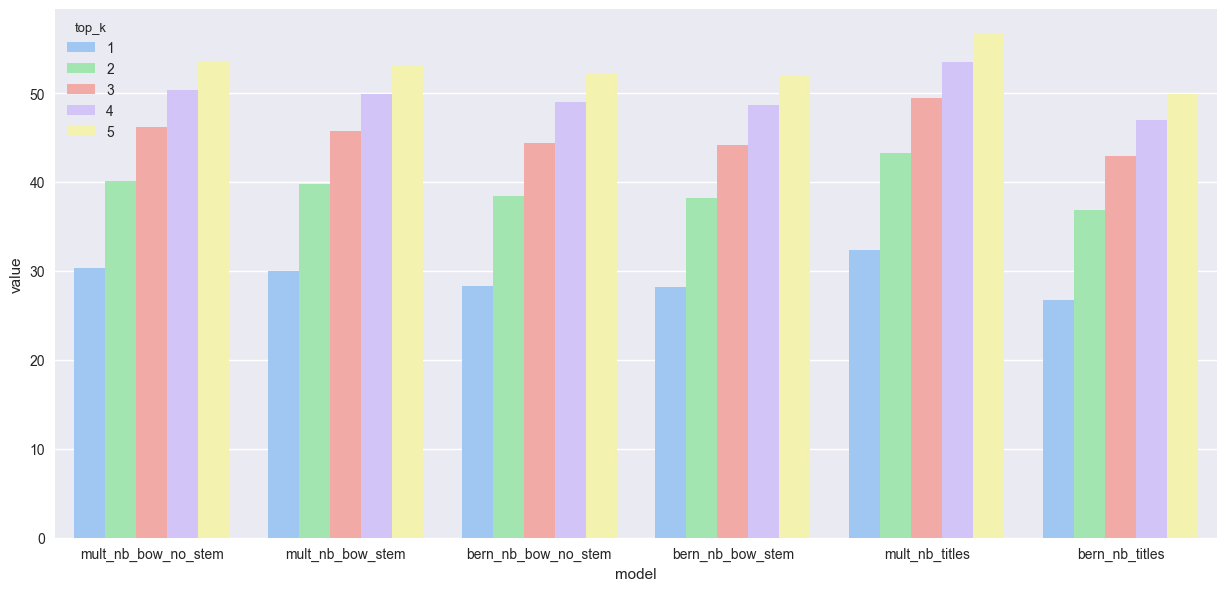

In [317]:
plt.rcParams['figure.figsize'] = 15, 7
plt.rcParams['figure.dpi'] = 100
ax = sns.barplot(x="model", y="value", hue="top_k", data=df)

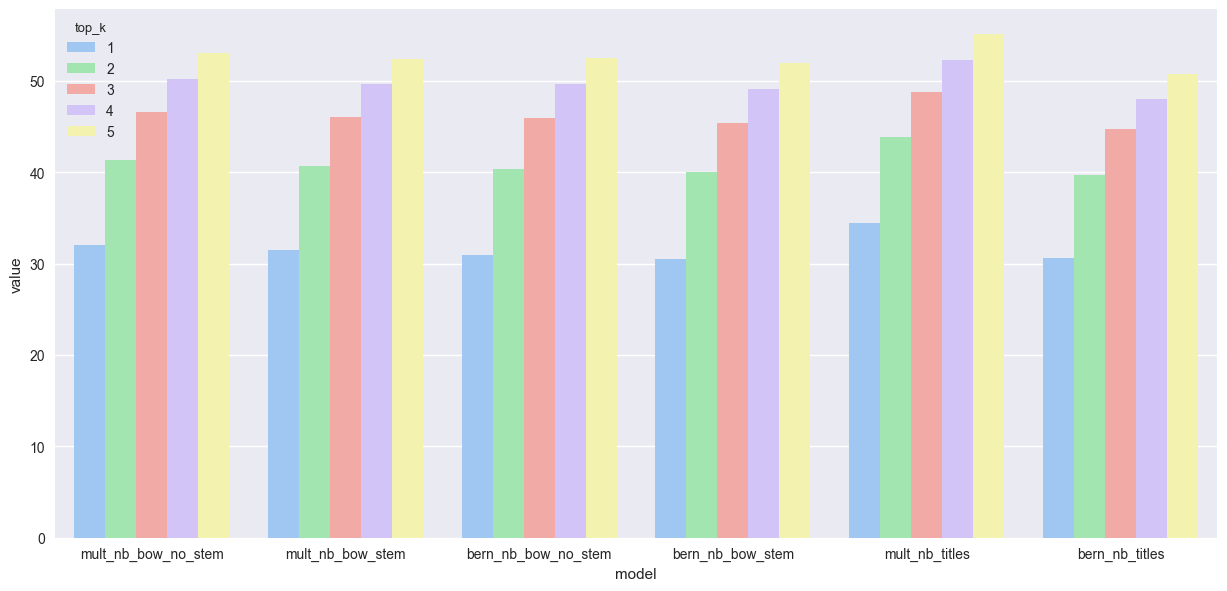

In [338]:
plt.rcParams['figure.figsize'] = 15, 7
plt.rcParams['figure.dpi'] = 100
ax = sns.barplot(x="model", y="value", hue="top_k", data=df)

# Reduced 7000 Data Set

## Tokenized Job Titles

### Without Stemming

In [213]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(reduced7000_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=False)

Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.15283537913461712
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.13177068725795


#### Multinomial NB Results

In [214]:
print_top_k_accs(multi_nb, X_test, test_targets)

acc: 15.25
top 2: 22.23
top 3: 26.64
top 4: 29.92
top 5: 32.57


#### Bernoulli NB

In [215]:
print_top_k_accs(nb, X_test, test_targets)

acc: 13.18
top 2: 19.65
top 3: 23.78
top 4: 26.97
top 5: 29.49


### With Stemming

In [219]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(reduced7000_path, 
                                                                            tokenized_titles=True, 
                                                                            use_stemmer=True)

Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.15173738952971436
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.13126943113397263


#### Multinomial NB Results

In [220]:
print_top_k_accs(multi_nb, X_test, test_targets)

acc: 15.14
top 2: 21.97
top 3: 26.43
top 4: 29.73
top 5: 32.35


#### Bernoulli NB

In [221]:
print_top_k_accs(nb, X_test, test_targets)

acc: 13.13
top 2: 19.61
top 3: 23.80
top 4: 27.01
top 5: 29.46


## Use Full Job Titles

In [225]:
multi_nb, nb, X_train, X_test, train_targets, test_targets = run_experiment(reduced7000_path, 
                                                                            tokenized_titles=False, 
                                                                            use_stemmer=False)

Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.16619624177253714
Training Naive Bayes...
Running trained model on test dataset
Model Accuracy: 0.1112609575185435


#### Multinomial NB Results

In [226]:
print_top_k_accs(multi_nb, X_test, test_targets)

acc: 16.59
top 2: 23.88
top 3: 28.37
top 4: 31.65
top 5: 34.32


#### Bernoulli NB

In [227]:
print_top_k_accs(nb, X_test, test_targets)

acc: 11.13
top 2: 16.81
top 3: 20.28
top 4: 22.93
top 5: 25.15
